# Exploración de hiperparámetros

In [1]:
import pandas as pd
import numpy as np
pd.set_option("max_rows", None)
from os import listdir
from os.path import isfile, join
import re
import os
import sys
import json
import pickle
import time

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rc('axes', titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'lines.markeredgewidth': 1})
plt.rcParams.update({'errorbar.capsize': 2})
tab_c = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink',
         'tab:gray','tab:olive','tab:cyan']

from MCMC_steiner_tree import Annealing, pre_pros, plot_graph_by_edges, Trans, weight, Annealing, read_stp, check_steiner_tree

In [18]:
root = {
    "main": "",  # "/Proyecto Sim. Est.",
    "data":"I080/",
    "data_I320":"/I320/",
    "I080": r"I080/i080-",
}

## Exploración preliminar

In [11]:
from MCMC_steiner_tree import Annealing, pre_pros, plot_graph_by_edges, Trans, weight, Annealing, read_stp, check_steiner_tree

In [12]:
df_opt = pd.read_excel('Testset_I320.xlsx', sheet_name="I080")
df_opt = df_opt.set_index("Name")
df_opt.head()

,|V|,|E|,|T|,DC,time,Opt
Name,,,,,,
i080-001,80.0,120.0,6.0,P,s,1787.0
i080-002,80.0,120.0,6.0,P,s,1607.0
i080-003,80.0,120.0,6.0,P,s,1713.0
i080-004,80.0,120.0,6.0,P,s,1866.0
i080-005,80.0,120.0,6.0,P,s,1790.0


In [19]:
id = "331"
df_edges_G, terminals = read_stp(root["main"]+root["I080"]+id+".stp")
df_G, dic_incidence, dic_edges, G = pre_pros(df_edges_G)
print("Terminals:", *terminals)
df_edges_G.head()

Terminals: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20


,SOURCE,TARGET,WEIGHT
0,1,6,297
1,1,9,306
2,1,13,300
3,1,54,194
4,1,57,200


In [20]:
opt = df_opt['Opt'][f"i080-{id}"]
opt

5226.0

In [21]:
save_rate = 1
nf = 400
median_weight = df_edges_G["WEIGHT"].median()
a = 0.5   #(1-e, 1+2*e)
b = 0.5
beta = [a*(n**b)*(1/median_weight) for n in range(nf)]

colors = ["orange", "red", "blue", "green", "gray", "pink"]

dic_annealing = {
    f"{g[0]}/{p}/{r[0]}, tab:{colors[int(g[1])*3 + _]}, {r[1]}":  Annealing(nf=nf, beta=beta, df_NB_G=df_G, dic_weight_edges=dic_edges, terminals=terminals, greedy=g[0], path_approach=p, remove_approach=r[0])
    for g in [("greedy", True), ("", False)] 
    for _, p in enumerate(["BFS", "DFS", "random"]) 
    for r in [("edge", "solid"), ("node", "dotted"), ("random", "dashdot")]
    }

In [22]:
U = np.random.uniform(size=nf)
V = np.random.uniform(size=nf)
for annealing in dic_annealing.values():
  annealing.MCMC(U, V, save_rate=save_rate)

In [23]:
def plot_peso(dic_cm, dic_edges, stp_id,ancho=1,stop=1000):
  fig, ax = plt.subplots(1, 1, figsize=(ancho*25*2*0.6, 18*0.6))
  N = len(list(dic_cm.items())[0][1])
  for info, cm in dic_cm.items():
    label, color, linestyle = info.split(", ")
    ax.plot([i*save_rate for i in range(N)][:stop],[weight(x, dic_edges) for x in cm][:stop], label=label, color=color, linestyle=linestyle)
  # ax.axhline(y=opt, color="tab:purple")
  ax.set_title('Peso del arbol {}, largo {}, dificultad {} ({})'.format(stp_id, df_opt['|E|'][stp_id],df_opt['DC'][stp_id],df_opt['time'][stp_id]), size=22)
  ax.set_xlabel("Iteración", size=22)
  ax.set_ylabel("Peso", size=22)
  handles, labels = ax.get_legend_handles_labels()
  display = (0,3,6,9, 12, 15)
  testArtist = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
  trainArtist = plt.Line2D((0,1),(0,0), color='k')
  errorArtist = plt.Line2D((0,1),(0,0), color='k', linestyle='-.')
  plt.legend([handle for i,handle in enumerate(handles) if i in display]+[trainArtist,testArtist,errorArtist],
              ["/".join(label.split("/")[:2]) for i,label in enumerate(labels) if i in display]+['edge', 'node', "random"], title='Variante', loc='best', ncol=3, fontsize=20, title_fontsize=20)
  # ax.legend();

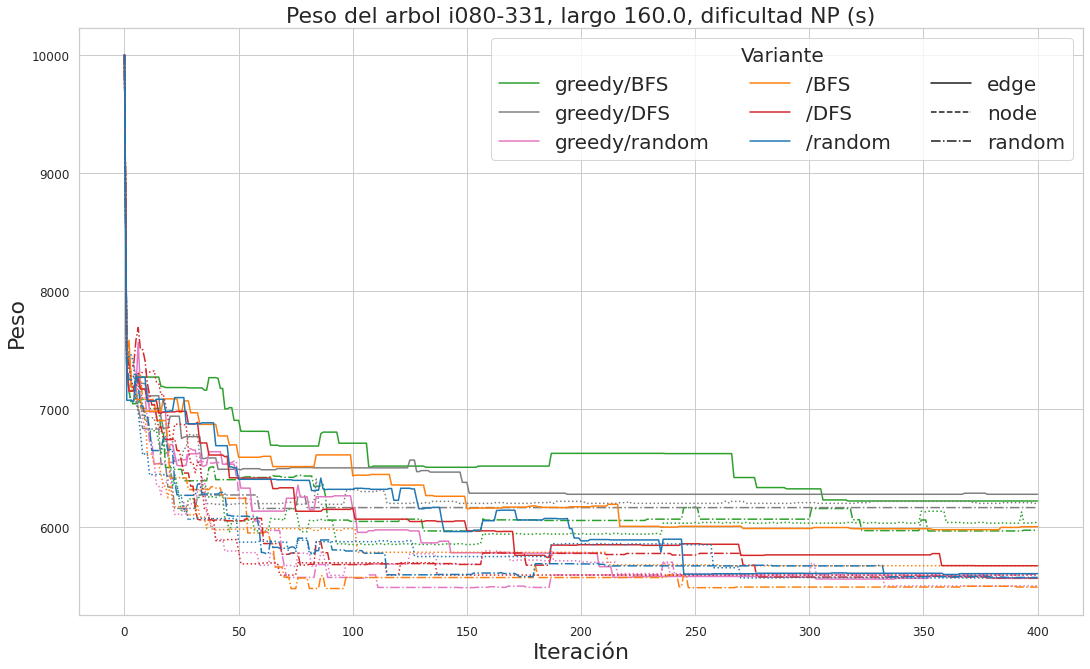

In [24]:
plot_peso({info: annealing.CM for info, annealing in dic_annealing.items()}, dic_edges, f"i080-{id}",ancho=.6)
plt.savefig(f"i080-{id}.pdf")

## Importando resultados

In [3]:
f = open('gridsearch0/gridsearch.json')
grid_search = json.load(f)
print(grid_search)
f.close()

{'a': [0.25, 0.5, 0.75, 1.0], 'b': [0.0, 0.25, 0.5, 0.75, 1.0]}


In [4]:
f = open('gridsearch0/params.json')
params = json.load(f)
print(params)
f.close()

{'nf': 3000, 'save_rate': 5, 'repeat': 10}


In [5]:
stp_names = ['i080-001.stp', 'i080-011.stp', 'i080-021.stp', 'i080-031.stp', 'i080-041.stp', 'i080-101.stp',
             'i080-111.stp', 'i080-121.stp', 'i080-131.stp', 'i080-141.stp', 'i080-201.stp', 'i080-211.stp',
             'i080-221.stp', 'i080-231.stp', 'i080-241.stp', 'i080-301.stp', 'i080-311.stp', 'i080-321.stp',
             'i080-331.stp', 'i080-341.stp']

In [7]:
with open('gridsearch0/UNIFORMS.pickle', 'rb') as handle:
    uniforms = pickle.load(handle)

In [8]:
methods = ['DFS_node']
a_values = grid_search['a']
b_values = grid_search['b']
len_U = len(uniforms)

In [9]:
class grafo_resultado(object):
    def __init__(self,name,len_U,df=df_opt,folder=root['main']+root['data'], root="gridsearch0"):
        name = name if not '.stp' in name else name.replace('.stp','')
        df_edges_G, terminals = read_stp(folder+name+'.stp')
        _, _, dic_edges, _ = pre_pros(df_edges_G)
        self.id = name
        self.terminals = terminals
        self.dic_edges = dic_edges
        self.opt = df['Opt'][name]
        self.size = int(df['|V|'][name])
        self.length = int(df['|E|'][name])
        self.difficulty = df['DC'][name]
        self.time = df['time'][name]
        self._results_loaded = False
        self._weights_computed = False
        self.len_U = len_U
        self.density = 2*self.length/(self.size*(self.size-1))
        self.root = root
        self.median_weight = np.median(list(dic_edges.values()))
        
    
    @staticmethod
    def load_cm_path(path):
        with open(path, 'rb') as handle:
            return pickle.load(handle)
    
    def get_results(self,methods,a_values=grid_search['a'],b_values=grid_search['b']):
        results = {}
        for m in methods:
            results[m] = {}
            for i, a in enumerate(a_values):
                results[m][a] = {}
                for j, b in enumerate(b_values):
                    results[m][a][b] = {}
                    for l in range(self.len_U):
                        file = self.root+'/{}/{}_ixa={}_ixb={}_ixu={}_CM.pickle'.format(self.id,m,i,j,l)
                        results[m][a][b][l] = self.load_cm_path(file)
        self.results = results
        self._results_loaded = True
    
    def compute_weight_cm(self):
        weight_cm = {}
        weight_avg, weight_std, weight_min, weight_max = {}, {}, {}, {}
        for m in methods:
            weight_cm[m] = {}
            weight_avg[m], weight_std[m] = {}, {}
            weight_min[m], weight_max[m] = {}, {}
            for a in a_values:
                weight_cm[m][a] = {}
                weight_avg[m][a], weight_std[m][a] = {}, {}
                weight_min[m][a], weight_max[m][a] = {}, {}
                for b in b_values:
                    weight_cm[m][a][b] = {}
                    weight_avg[m][a][b], weight_std[m][a][b] = {}, {}
                    weight_min[m][a][b], weight_max[m][a][b] = {}, {}
                    for l in range(self.len_U):
                        weight_cm[m][a][b][l] = [weight(x, self.dic_edges) for x in self.results[m][a][b][l]]
                    weight_avg[m][a][b], weight_std[m][a][b] = self.avg_weights(weight_cm[m][a][b])
                    weight_min[m][a][b], weight_max[m][a][b] = self.min_max_weights(weight_cm[m][a][b])
        self.weight_cm = weight_cm
        self.weight_avg = weight_avg
        self.weight_std = weight_std
        self.weight_min = weight_min
        self.weight_max = weight_max
        self._weights_computed = True
        self.compute_weight_final()
    
    @staticmethod
    def avg_weights(weights_unif):
        N = len(weights_unif)
        weights_unif = np.array(list(weights_unif.values()))
        weights_avg = np.mean(weights_unif,axis=0)
        weights_std = np.std(weights_unif,axis=0)
        return list(weights_avg), list(weights_std)
    
    @staticmethod
    def min_max_weights(weights_unif):
        N = len(weights_unif)
        weights_unif = np.array(list(weights_unif.values()))
        weights_min = np.min(weights_unif,axis=0)
        weights_max = np.max(weights_unif,axis=0)
        return list(weights_min), list(weights_max)
    
    def compute_weight_final(self):
        weight_final = {}
        weight_best = {}
        for m in methods:
            weight_final[m] = {}
            weight_best[m] = {}
            for a in a_values:
                weight_final[m][a] = {}
                weight_best[m][a] = {}
                for b in b_values:
                    weight_final[m][a][b] = {}
                    weight_best[m][a][b] = {}
                    for l in range(self.len_U):
                        if self._weights_computed:
                            weight_final[m][a][b][l] = self.weight_cm[m][a][b][l][-1]
                            weight_best[m][a][b][l] = np.min(self.weight_cm[m][a][b][l])
#                         else:
#                             x = self.results[m][a][b][l][-1]
#                             weight_final[m][a][b][l] = weight(x, self.dic_edges)
        self.weight_final = weight_final
        self.weight_best = weight_best

In [10]:
%%time
grafo = 'i080-001'
grafo_result = grafo_resultado(grafo,len_U)
grafo_result.get_results(methods)
# grafo_result.results['BFS_node'][0.875][0.25]

CPU times: user 500 ms, sys: 25.6 ms, total: 525 ms
Wall time: 568 ms


In [11]:
%%time
grafo_result.compute_weight_cm()

CPU times: user 774 ms, sys: 62 µs, total: 774 ms
Wall time: 773 ms


In [12]:
%%time
result_grafos = {}
for grafo in stp_names:
    print(grafo)
    # sacar stp
    result_grafos[grafo] = grafo_resultado(grafo,len_U)
    result_grafos[grafo].get_results(methods)
    result_grafos[grafo].compute_weight_cm()

i080-001.stp
i080-011.stp
i080-021.stp
i080-031.stp
i080-041.stp
i080-101.stp
i080-111.stp
i080-121.stp
i080-131.stp
i080-141.stp
i080-201.stp
i080-211.stp
i080-221.stp
i080-231.stp
i080-241.stp
i080-301.stp
i080-311.stp
i080-321.stp
i080-331.stp
i080-341.stp
CPU times: user 37.1 s, sys: 768 ms, total: 37.8 s
Wall time: 38.5 s


In [13]:
def plot_a(grafo_result,a_values,b,unif='mean',log=False):
    # unif: 'mean' (str) or index (int)
    fig, ax = plt.subplots(1, 1, figsize=(25*2*0.3, 18*0.3))
    N = len(grafo_result.weight_avg[methods[0]][a_values[0]][b_values[0]])
    Ns = [i*params['save_rate'] for i in range(N)]
    for i, a in enumerate(a_values):
        if unif=='mean':
            values_dfs = grafo_result.weight_avg['DFS_node'][a][b][1:]
#             values_bfs = grafo_result.weight_avg['BFS_node'][a][b][1:]
        else:
            values_dfs = grafo_result.weight_cm['DFS_node'][a][b][unif][1:]
#             values_bfs = grafo_result.weight_cm['BFS_node'][a][b][unif][1:]
        ax.plot(Ns[1:], values_dfs, color=tab_c[i], label='DFS_node a={}'.format(a), linestyle='dotted')
#         ax.plot(Ns[1:], values_bfs, color=tab_c[i], label='BFS_node a={}'.format(a), linestyle='solid')
    ax.legend()
    ax.axhline(y=grafo_result.opt, color="limegreen")
    ax.set_title('Pesos para distintos valores de a, grafo = {}, b={}'.format(grafo_result.id,b))
    if log:
        ax.set_yscale('log')

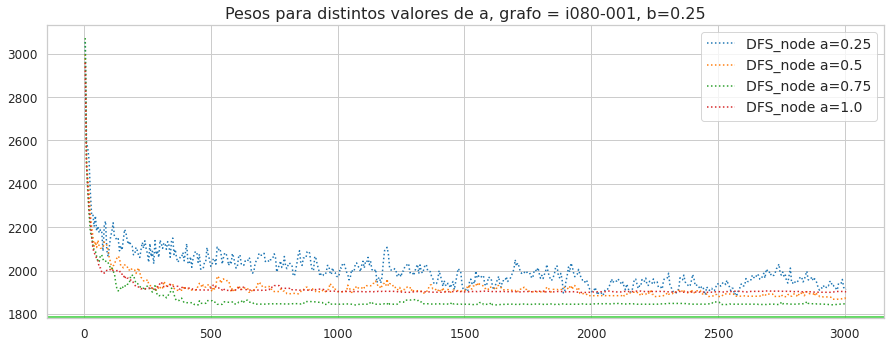

In [14]:
b = 0.25
plot_a(result_grafos["i080-001.stp"],a_values,b,unif='mean');

In [15]:
def plot_b(grafo_result,b_values,a,unif='mean',log=False):
    # unif: 'mean' (str) or index (int)
    fig, ax = plt.subplots(1, 1, figsize=(25*2*0.3, 18*0.3))
    N = len(grafo_result.weight_avg[methods[0]][a_values[0]][b_values[0]])
    Ns = [i*params['save_rate'] for i in range(N)]
    for j, b in enumerate(b_values):
        if unif=='mean':
            values_dfs = grafo_result.weight_avg['DFS_node'][a][b][1:]
#             values_bfs = grafo_result.weight_avg['BFS_node'][a][b][1:]
        else:
            values_dfs = grafo_result.weight_cm['DFS_node'][a][b][unif][1:]
#             values_bfs = grafo_result.weight_cm['BFS_node'][a][b][unif][1:]
        ax.plot(Ns[1:], values_dfs, color=tab_c[j], label='DFS_node b={}'.format(b), linestyle='dotted')
#         ax.plot(Ns[1:], values_bfs, color=tab_c[j], label='BFS_node b={}'.format(a), linestyle='solid')
    ax.legend()
    ax.axhline(y=grafo_result.opt, color="limegreen")
    ax.set_title('Pesos para distintos valores de b, grafo = {}, a={}'.format(grafo_result.id,a))
    if log:
        ax.set_yscale('log')

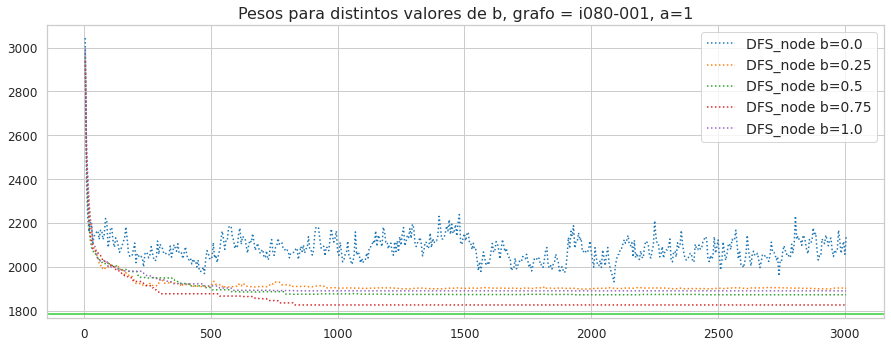

In [16]:
a = 1
plot_b(result_grafos["i080-001.stp"],b_values,a);

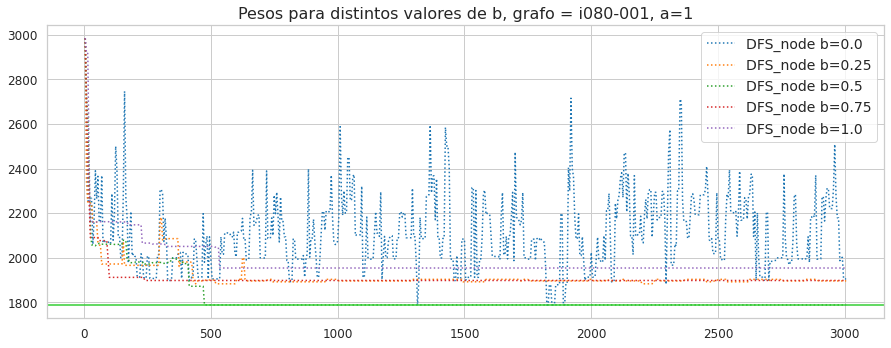

In [17]:
a = 1
plot_b(result_grafos["i080-001.stp"],b_values,a, unif=0);

In [18]:
def plot_ab_uniforms(grafo_result,a,b,interval=None,log=False,factor=2,below_only=False):
    # interval: None, 'std' or 'minmax'
    # factor: float, factor that multiplies the std for plotting confidence interval
    # below_only: whether it fills only under the mean 
    fig, ax = plt.subplots(1, 1, figsize=(25*2*0.3, 18*0.3))
    N = len(grafo_result.weight_avg[methods[0]][a_values[0]][b_values[0]])
    Ns = [i*params['save_rate'] for i in range(N)]
    if interval=='std':
        values_dfs = grafo_result.weight_avg['DFS_node'][a][b]
#         values_bfs = grafo_result.weight_avg['BFS_node'][a][b]
        ax.plot(Ns[1:], values_dfs[1:], color=tab_c[0], label='DFS_node', linestyle='dotted', linewidth=2)
#        ax.plot(Ns[1:], values_bfs[1:], color=tab_c[1], label='BFS_node', linestyle='solid', linewidth=2)
        
        std_dfs = np.array(grafo_result.weight_std['DFS_node'][a][b])
#        std_bfs = np.array(grafo_result.weight_std['BFS_node'][a][b])
#        values_bfs = np.array(values_bfs)
        values_dfs = np.array(values_dfs)
#         under_line_bfs = values_bfs-factor*std_bfs
        under_line_dfs = values_dfs-factor*std_dfs
        if not below_only:
#             over_line_bfs = values_bfs+factor*std_bfs
            over_line_dfs = values_dfs+factor*std_dfs
        else:
#            over_line_bfs = values_bfs
            over_line_dfs = values_dfs
            
        plt.fill_between(Ns[1:], under_line_dfs[1:], over_line_dfs[1:], color=tab_c[0], alpha=.1)
#        plt.fill_between(Ns[1:], under_line_bfs[1:], over_line_bfs[1:], color=tab_c[1], alpha=.1)
    elif interval=='minmax':
        values_dfs = grafo_result.weight_avg['DFS_node'][a][b]
#        values_bfs = grafo_result.weight_avg['BFS_node'][a][b]
        ax.plot(Ns[1:], values_dfs[1:], color=tab_c[0], label='DFS_node', linestyle='dotted', linewidth=2)
#        ax.plot(Ns[1:], values_bfs[1:], color=tab_c[1], label='BFS_node', linestyle='solid', linewidth=2)
        
        min_dfs, max_dfs = grafo_result.weight_min['DFS_node'][a][b], grafo_result.weight_max['DFS_node'][a][b]
#        min_bfs, max_bfs = grafo_result.weight_min['BFS_node'][a][b], grafo_result.weight_max['BFS_node'][a][b]

        plt.fill_between(Ns[1:], min_dfs[1:], max_dfs[1:], color=tab_c[0], alpha=.1)
#        plt.fill_between(Ns[1:], min_bfs[1:], max_bfs[1:], color=tab_c[1], alpha=.1)
    else:
        for l in range(grafo_result.len_U):
            values_dfs = grafo_result.weight_cm['DFS_node'][a][b][l][1:]
#            values_bfs = grafo_result.weight_cm['BFS_node'][a][b][l][1:]
            ax.plot(Ns[1:], values_dfs, color=tab_c[l], label='DFS_node unif={}'.format(l), linestyle='dotted')
#            ax.plot(Ns[1:], values_bfs, color=tab_c[l], label='BFS_node unif={}'.format(l), linestyle='solid')
    ax.legend()
    ax.axhline(y=grafo_result.opt, color="limegreen")
    ax.set_title('Pesos para distintas uniformes, grafo = {}, a={}, b={}'.format(grafo_result.id,a,b))
    if log:
        ax.set_yscale('log')

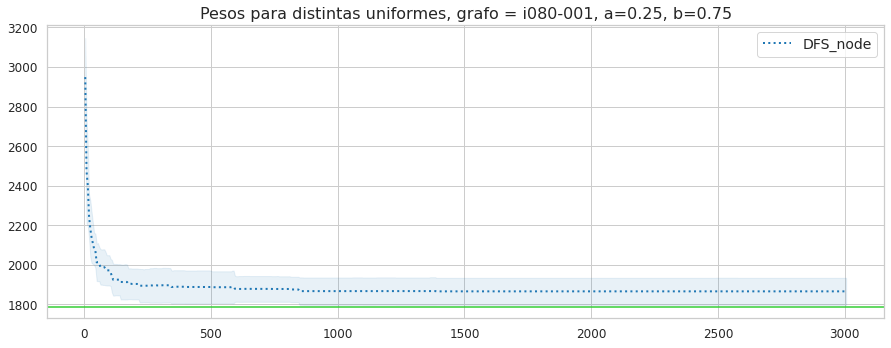

In [19]:
a = 0.25
b = 0.75
plot_ab_uniforms(result_grafos["i080-001.stp"],a,b,interval='std',factor=1);

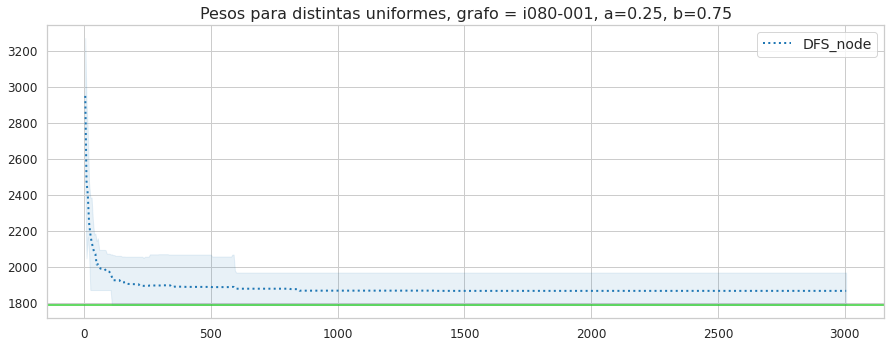

In [20]:
plot_ab_uniforms(result_grafos["i080-001.stp"],a,b,interval='minmax',factor=1);

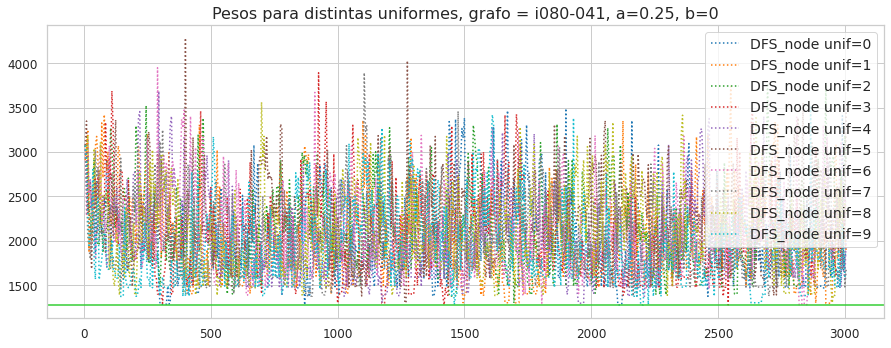

In [21]:
a = 0.25
b = 0
plot_ab_uniforms(result_grafos["i080-041.stp"],a,b);

---

In [22]:
def plot_ab_grid_single_method(grafo_obj,metodo,a_values,b_values,unif='mean', norm=True):
    matrix = np.zeros((len(a_values),len(b_values)))
    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            if unif=='mean':
                matrix[i][j] = np.mean(np.array(list(grafo_obj.weight_final[metodo][a][b].values())),axis=0)
                matrix[i][j] = matrix[i][j] - grafo_obj.opt
            else:
                matrix[i][j] = grafo_obj.weight_final[metodo][a][b][unif] - grafo_obj.opt
    matrix *= (1/grafo_obj.median_weight) if norm else 1
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(8, 6))
        vmax_value = 350
        vmax_value *= (1/grafo_obj.median_weight) if norm else 1
        ax = sns.heatmap(matrix.T, square=True,xticklabels=a_values, vmax=vmax_value,
                         vmin=0, yticklabels=b_values, linewidths=.5)
        plt.title('Error para valores de a y b, grafo: {},, metodo={}'.format(grafo_result.id,metodo))
        plt.show()

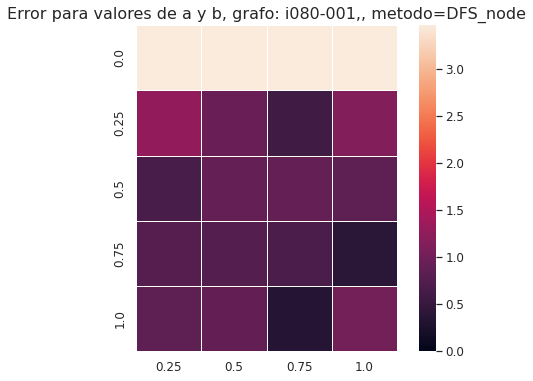

In [24]:
plot_ab_grid_single_method(result_grafos["i080-001.stp"],'DFS_node',a_values,b_values, unif="mean", norm=True)
# plot_ab_grid_single_method(grafo_result,'BFS_node',a_values,b_values)

In [25]:
def plot_ab_grid(grafo_obj,metodos,a_values,b_values,fig=None,ax=None,unif='mean', norm=True):
    if not fig and not ax:
          fig, (ax1, ax2, axcb) = plt.subplots(1, 3, gridspec_kw={'width_ratios':[1,1,0.08]})
#         fig, (ax1, axcb) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.08]})
    else:
        ax1, ax2, axcb = ax
#         ax1, axcb = ax
    ax1.get_shared_y_axes().join(ax2)
    matrix1 = np.zeros((len(a_values),len(b_values)))
    matrix2 = np.zeros((len(a_values),len(b_values)))
    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):                
            # matrix1[i][j] = grafo_obj.weight_final[metodos[0]][a][b] - grafo_obj.opt
            # matrix2[i][j] = grafo_obj.weight_final[metodos[1]][a][b] - grafo_obj.opt
            if unif=='mean':
                matrix1[i][j] = np.mean(np.array(list(grafo_obj.weight_final[metodos[0]][a][b].values())),axis=0)
                matrix1[i][j] = matrix1[i][j] - grafo_obj.opt
                matrix2[i][j] = np.mean(np.array(list(grafo_obj.weight_best[metodos[0]][a][b].values())),axis=0)
                matrix2[i][j] = matrix2[i][j] - grafo_obj.opt
            else:
                matrix1[i][j] = grafo_obj.weight_final[metodos[0]][a][b][unif] - grafo_obj.opt
                matrix2[i][j] = grafo_obj.weight_best[metodos[0]][a][b][unif] - grafo_obj.opt
    matrix1 *= (1/grafo_obj.median_weight) if norm else 1
    matrix2 *= (1/grafo_obj.median_weight) if norm else 1
    avg1 = np.mean(matrix1)
    avg2 = np.mean(matrix2)
    with sns.axes_style("white"):
        vmax_value = 350
        vmax_value = 3.5 if norm else 1
        g1 = sns.heatmap(matrix1.T, square=True, xticklabels=a_values, yticklabels=b_values, vmax=vmax_value,
                         vmin=0, cbar=False, linewidths=.5, ax=ax1, annot=True)
        g2 = sns.heatmap(matrix2.T, square=True, xticklabels=a_values, yticklabels=b_values, vmax=vmax_value,
                         vmin=0, linewidths=.5, ax=ax2, cbar_ax=axcb, annot=True)
        v, e, t = int(grafo_obj.size), int(grafo_obj.length), len(grafo_obj.terminals)
        titulo = 'Error para valores de a y b, \n grafo: {}, |V|={}, |E|={}, |T|={}'.format(grafo_obj.id,v,e,t)
        fig.suptitle(titulo, size=18)
#         ax1.set_title('Método {}'.format(metodos[0]))
#         ax2.set_title('Metodo {}'.format(metodos[1]))
        ax1.set_title('Final')
        ax2.set_title('Minimo')
        #plt.show()
    ax1.set(xlabel='a', ylabel='b')
    ax2.set(xlabel='a')
    fig.tight_layout()
    
    plt.savefig("entregables/graficos/"+titulo+"_{}.png".format(unif))
    
    return ax1, ax2, axcb, avg1, avg2
#     return ax1, _, axcb, avg1, _

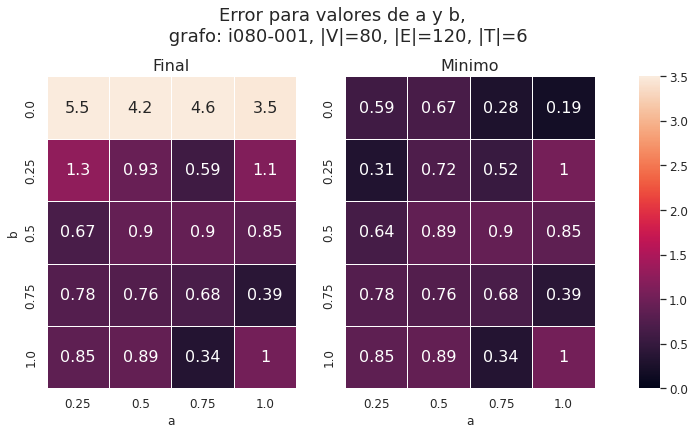

In [26]:
plot_ab_grid(result_grafos["i080-001.stp"],methods,a_values,b_values);

---

In [27]:
def densidad(grafo_obj):
    v = grafo_obj.size
    e = grafo_obj.length
    # grado = e/v
    # return 2*e/v*(v-1)
    return len(grafo_obj.terminals)

# print(densidad(result_grafos['i080-221.stp']))
# sorted(densidades.items(), key=lambda x: x[1], reverse=False)
densidades = {}
for grafo in stp_names:
    densidades[grafo] = densidad(result_grafos[grafo])

In [28]:
%matplotlib notebook
import matplotlib.pyplot as plt
import time

<IPython.core.display.Javascript object>


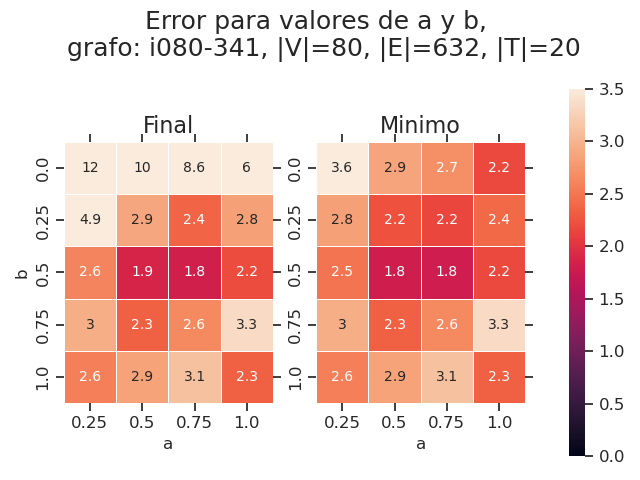

In [29]:
sleep = 1 # segundo

fig, (ax1, ax2, axcb) = plt.subplots(1, 3, gridspec_kw={'width_ratios':[1,1,0.08]})
# fig, (ax1, axcb) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.08]})
ax1.get_shared_y_axes().join(ax2)
plt.ion()
# # fig.show()
# fig.canvas.draw()

dic_avg = {}

for g_id in sorted(densidades.items(), key=lambda x: x[1], reverse=False):  # result_grafos.keys():
    g_id = g_id[0]
    ax1.clear()
    ax2.clear()
    axcb.clear()
    ax1, ax2, axcb, avg1, avg2 = plot_ab_grid(result_grafos[g_id],methods,a_values,b_values,fig,(ax1, ax2, axcb))
#     ax1, ax2, axcb, avg1, avg2 = plot_ab_grid(result_grafos[g_id],methods,a_values,b_values,fig,(ax1, axcb))
    dic_avg[g_id] = (avg1, avg2)
    fig.canvas.draw()
    time.sleep(sleep)

<IPython.core.display.Javascript object>


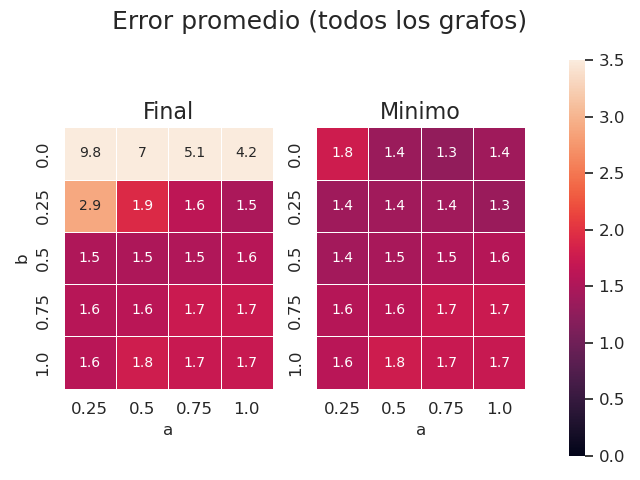

In [31]:
fig, (ax1, ax2, axcb) = plt.subplots(1, 3, gridspec_kw={'width_ratios':[1,1,0.08]})
ax1.get_shared_y_axes().join(ax2)
# fig, (ax1, axcb) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.08]})
norm=True
matrix1 = np.zeros((len(a_values),len(b_values)))
matrix2 = np.zeros((len(a_values),len(b_values)))
for g_id in result_grafos.keys():
    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            # matrix1[i][j] += result_grafos[g_id].weight_final[methods[0]][a][b] - result_grafos[g_id].opt
            # matrix2[i][j] += result_grafos[g_id].weight_final[methods[1]][a][b] - result_grafos[g_id].opt
            
            m1 = np.mean(np.array(list(result_grafos[g_id].weight_final[methods[0]][a][b].values())),axis=0)
            error_relative1 = m1 - result_grafos[g_id].opt
            error_relative1 *= (1/result_grafos[g_id].median_weight) if norm else 1
            matrix1[i][j] += error_relative1
            m2 = np.mean(np.array(list(result_grafos[g_id].weight_best[methods[0]][a][b].values())),axis=0)
            error_relative2 = m2 - result_grafos[g_id].opt
            error_relative2 *= (1/result_grafos[g_id].median_weight) if norm else 1
            matrix2[i][j] += error_relative2
            
matrix1, matrix2 = matrix1/len(stp_names), matrix2/len(stp_names)
# matrix1 = matrix1/len(stp_names)

with sns.axes_style("white"):
    vmax_value = 3.5 if norm else 350
    g1 = sns.heatmap(matrix1.T, square=True, xticklabels=a_values, yticklabels=b_values, vmax=vmax_value,
                     vmin=0, cbar=False, linewidths=.5, ax=ax1, annot=True)
    g2 = sns.heatmap(matrix2.T, square=True, xticklabels=a_values, yticklabels=b_values, vmax=vmax_value,
                     vmin=0, linewidths=.5, ax=ax2, cbar_ax=axcb, annot=True)
    titulo = 'Error promedio (todos los grafos)'
    fig.suptitle(titulo, size=18)
    ax1.set_title('Final')
    ax2.set_title('Minimo')
ax1.set(xlabel='a', ylabel='b');
ax2.set(xlabel='a');
fig.tight_layout()
plt.savefig("entregables/graficos/"+titulo+".png")

In [169]:
def display_grid_unifs(grafo_obj,sleep=1):
#     fig, (ax1, ax2, axcb) = plt.subplots(1, 3, gridspec_kw={'width_ratios':[1,1,0.08]})
#     ax1.get_shared_y_axes().join(ax2)
    fig, (ax1,axcb) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.08]})
    plt.ion()
    fig.show()
    fig.canvas.draw()

    dic_avg = {}

    for l in range(len_U):
        ax1.clear()
#         ax2.clear()
        axcb.clear()
        ax1, ax2, axcb, avg1, avg2 = plot_ab_grid(grafo_obj,methods,a_values,b_values,fig,(ax1, axcb),unif=l)
        dic_avg[g_id] = (avg1, avg2)
        fig.canvas.draw()
        time.sleep(sleep)

<IPython.core.display.Javascript object>


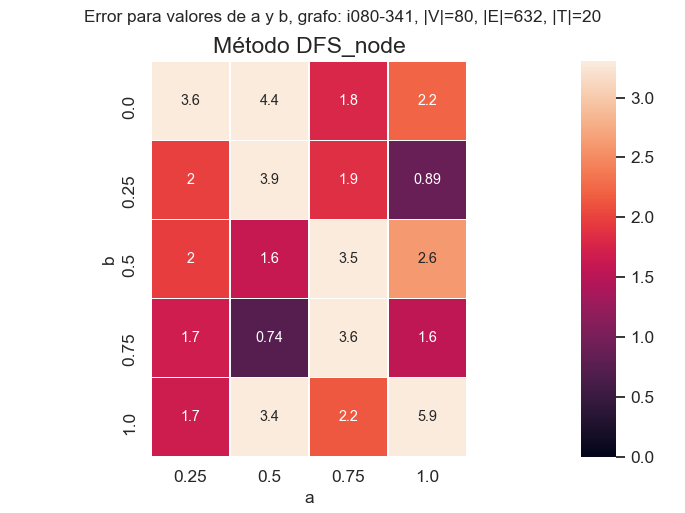

In [176]:
display_grid_unifs(result_grafos["i080-341.stp"])

---